In [16]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import os 
import matplotlib.pyplot as plt
import numpy as np

## IDEA DEL EXPERIMENTO
+ Optimizar el autoencoder probando diferentes cantidad de neuronas en la capa de restricción


In [17]:
os.chdir( "C:\\Users\\vyago\\Desktop\\Maestría Ciencias de Datos\\07-DMEYF" )

dataset = pd.read_csv("./datasets/competencia2_2022.csv.gz", low_memory=False)


enero = dataset.loc[dataset["foto_mes"]==202101]
marzo = dataset.loc[dataset["foto_mes"]==202103]


In [18]:
enero=enero.fillna(enero.mean()) # RELLENO CON LA MEDIA DE CADA COLUMNA LOS VALORES NULOS, LO NECESITA LA RED
marzo = marzo.fillna(enero.mean())

C:\Users\vyago\AppData\Local\Temp\ipykernel_2224\1451727993.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  enero=enero.fillna(enero.mean()) # RELLENO CON LA MEDIA DE CADA COLUMNA LOS VALORES NULOS, LO NECESITA LA RED
C:\Users\vyago\AppData\Local\Temp\ipykernel_2224\1451727993.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  marzo = marzo.fillna(enero.mean())


In [19]:

marzo["clase_binaria"] = marzo["clase_ternaria"].apply(lambda x: 1 if x=="CONTINUA" else 0) #CLASE COMBINADA
enero["clase_binaria"] = enero["clase_ternaria"].apply(lambda x: 1 if x=="CONTINUA" else 0) # CLASE COMBINADA
drop = ["clase_binaria","clase_ternaria","foto_mes","numero_de_cliente"]
X_train = enero[enero.columns.drop( drop)] # DATASET DE ENTRENAMIENTO
y_train = enero["clase_binaria"] # ETIQUETAS ENTRENAMIENTO
X_test = marzo[marzo.columns.drop(drop)] # DATASET DE TEST
y_test = marzo["clase_binaria"] # ETIQUETAS DE TEST


In [20]:
# ESCALADO DE FEATURES 
train_max = X_train.max()
train_min = X_train.min()


train_data = (X_train - train_min)/(train_max - train_min)
test_data = (X_test - train_min)/(train_max - train_min) # ESCALO CON VALORES DE TRAIN


## Modelo

Experimento con diferentes valores de la capa de incrustación interna 

In [21]:


class AnomalyDetector(Model):
  def __init__(self,reductor):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(reductor*4,activation="relu"),
      layers.Dense(reductor*3, activation="relu"),
      layers.Dense(reductor*2, activation="relu"),
      layers.Dense(reductor, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(reductor*2, activation="relu"),
      layers.Dense(reductor*3, activation="relu"),
      layers.Dense(reductor*4,activation="relu"),
      layers.Dense(152, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded



In [22]:

#CALCULAR GANANCIA
def ganancia (normal,anormal):
    gan = 78000*anormal-2000*normal
    return gan


#ITERAR PARA BUSCAR PUNTO DE CORTE Y GANANCIA MÁXIMA
def corte (train_loss,test_loss):
    anormal = test_loss.numpy()
    normal = train_loss.numpy()
    ganancia_max = -2000000
    thresold = None
    cantidad_envios= None
    for c in np.arange(0.01,0.08,0.0001):
        cant_normal = np.count_nonzero(normal > c)
        cant_anormal = np.count_nonzero( anormal > c)
        gan = ganancia (cant_normal,cant_anormal)
        if gan >ganancia_max:
            threshold = c
            ganancia_max = gan
            cantidad_envios = cant_normal+cant_anormal
    return threshold,ganancia_max,cantidad_envios



In [23]:
# Evaluar modelos
def evaluar(modelo,normal_train_data,anomalous_train_data):
    
    reconstruccion=modelo.predict(normal_train_data)
    train_nor_loss = tf.keras.losses.mae(reconstruccion, normal_train_data)
    
    reconstruccion_error = modelo.predict(anomalous_train_data)
    test_an_loss = tf.keras.losses.mae(reconstruccion_error, anomalous_train_data)
    
    cor,ganancia_maxima,_=corte(train_nor_loss,test_an_loss)
    
    return (cor,ganancia_maxima)
    
    

In [26]:
def experimento(train_data,test_data):
    
    train_data = tf.cast(train_data, tf.float32)
    test_data = tf.cast(test_data, tf.float32)

    train_labels = y_train.values.astype(bool)
    test_labels = y_test.values.astype(bool)

    normal_train_data = train_data[train_labels]
    normal_test_data = test_data[test_labels]

    anomalous_train_data = train_data[~train_labels]
    anomalous_test_data = test_data[~test_labels]
    
    
    
    reduccion=[8,16,20]
    experimento={}
    c = []
    ganancia_maxima = []
    
    for reductor in reduccion:
        autoencoder = AnomalyDetector(reductor)
        autoencoder.compile(optimizer='adam', loss='mae')
        history = autoencoder.fit(normal_train_data, normal_train_data, 
            epochs=500, 
            batch_size=512,
            validation_data=(normal_test_data, normal_test_data),
            shuffle=True)
        experimento[f'modelo_r{reductor}']=history
        
        cor,gan_max = evaluar(autoencoder,normal_train_data,anomalous_train_data)
        c.append(cor)
        ganancia_maxima.append(gan_max)
        
    return (experimento,c,ganancia_maxima)
        
        

In [27]:
experiencias,cortes,ganancias=experimento(train_data,test_data)

Epoch 1/500
313/313 [==============================] - 1s 4ms/step - loss: 0.0646 - val_loss: 0.0189
Epoch 2/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0185 - val_loss: 0.0182
Epoch 3/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 4/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 5/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0149
Epoch 6/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0148 - val_loss: 0.0147
Epoch 7/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 8/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0146 - val_loss: 0.0145
Epoch 9/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 10/500
313/313 [==============================] - 1s 3ms/step - loss: 0.0144 - val_lo

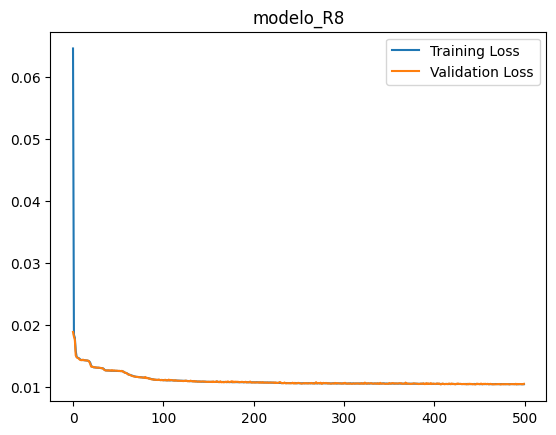

In [46]:
plt.plot(experiencias["modelo_r8"].history["loss"], label="Training Loss")
plt.plot(experiencias["modelo_r8"].history["val_loss"], label="Validation Loss")
plt.title("modelo_R8")
plt.legend()

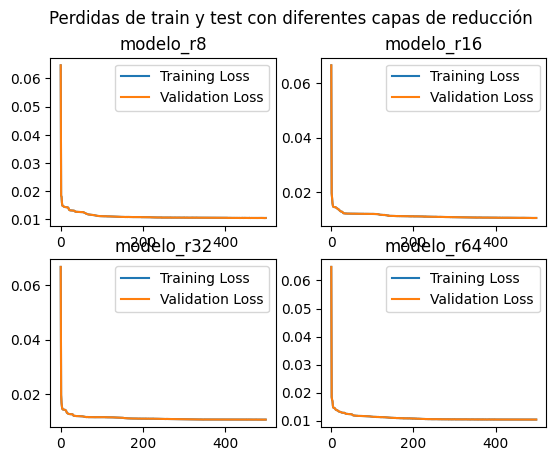

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('Perdidas de train y test con diferentes capas de reducción')
ax1.plot(experiencias["modelo_r8"].history["loss"], label="Training Loss")
ax1.plot(experiencias["modelo_r8"].history["loss"], label="Validation Loss")
ax1.set_title("modelo_r8")
ax1.legend()
ax2.plot(experiencias["modelo_r16"].history["loss"], label="Training Loss")
ax2.plot(experiencias["modelo_r16"].history["loss"], label="Validation Loss")
ax2.set_title("modelo_r16")
ax2.legend()
ax3.plot(experiencias["modelo_r32"].history["loss"], label="Training Loss")
ax3.plot(experiencias["modelo_r32"].history["loss"], label="Validation Loss")
ax3.set_title("modelo_r32")
ax3.legend()
ax4.plot(experiencias["modelo_r64"].history["loss"], label="Training Loss")
ax4.plot(experiencias["modelo_r64"].history["loss"], label="Validation Loss")
ax4.set_title("modelo_r64")
ax4.legend()


Text(0.5, 1.0, 'Ganancias de entrenamiento máximas por modelo')

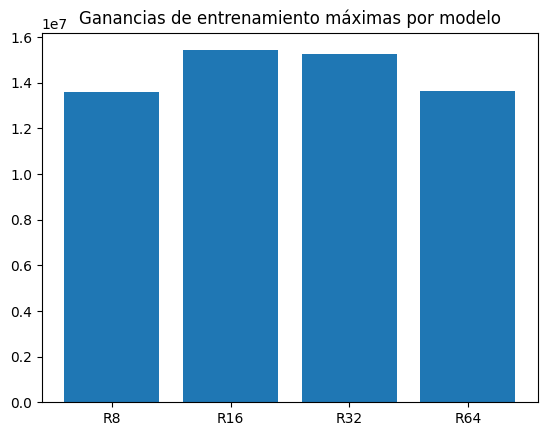

In [39]:
# GANANCIAS POR MODELO

modelos = ["R8","R16","R32","R64"]
plt.bar(x=modelos,height=ganancias)
plt.title("Ganancias de entrenamiento máximas por modelo")